En este notebook se realizan diversos bloques de scripts para el análisis de las funciones tipo timer, saber rango de tiempo de uso de una función, saber el periodo con el que una función es llamada, saber el primer minuto en la que una función es llamada.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
from pathlib import Path
from tqdm import tqdm

In [11]:
#devuelve lista de nombres csv
def invoc_per_func(ruta = Path.cwd()):
    return  [arch.name for arch in Path(ruta).glob('invocations_per_function_md.anon.d[01][0-9].csv')]

invoc_func = invoc_per_func() 
invoc_per_func= pd.DataFrame()

In [3]:
def tam(obj):
    print(str(sys.getsizeof(obj)/ 1000000) + " MB")

In [15]:
#devuelve el rango en minutos en el que una función es llamada
def rango(df):
    ran = []
    for (index, fila) in df.iterrows():
        cont = 0
        fin = 0 
        for m in fila.values:
            cont+=1
            if(m == 1):
                ini = cont
                cont = 0
                break
        for m in reversed(fila.values):
            cont+=1
            if(m == 1):
                fin = 1441 - cont 
                cont = 0
                break
        if((fin - ini) == 0): # evitamos rango 0 en registros unicos por dia 
            ran.append(1)
            
        else:
            ran.append(fin - ini)
    
    df['rango_min'] = ran
    del ran

# punto 1, retorna invocaciones_timer_2 
para analisis humano, y prueba de metodo de procesamiento
no necesario replicar, es para validar que los datos de salida que esten correctos
se puede saltar a "metodo para resultado de los 14 dias"

In [5]:
# sustrae Funciones solo timer, elimina columnas no necearias y agrega el perido de invocacion para cada funcion  
def clean_laps_df(df):
    cond = df.loc[df['Trigger'] != "timer"].index # condicicon para elimitar trigger que no son timer 
    df= df.drop(cond, inplace=False).reset_index(drop = True) # False porque no se puede reset index directo  
    df.drop(['HashOwner', 'HashApp', 'Trigger'], axis = 1, inplace = True)
    df.set_index('HashFunction',inplace=True) # para hacer sencillo el reemplazo de # de invocaciones por minuto 
    df=df.where(df <= 1, 1)                 # si se invo 12veces en un minuto se reeplaza a 1 para analizar periodicidad 
    desv =df.std(axis=1) # guardamos desv Estandar 
    #df["ivocationDay"] = df.iloc[:, 0:].sum(axis=1)
    invocaciones = pd.Series(df.iloc[:, 0:].sum(axis=1)) # llevamos conteo de # de aparicicones en el dia de una funcion
    rango(df) # ingres rango_min al df 
    df["ivocationDay"] = invocaciones
    del invocaciones
    df["DesEst"] = desv
    del desv
    ## ya no df["periodo"] = df["ivocationDay"].apply(lambda x: 1440 /x) 
    df["periodo"] = df.apply(lambda x: 1440 if (x["ivocationDay"]==1) else (x["rango_min"]/(x["ivocationDay"]-1)) , axis = 1) 
    df["periodo"] = df["periodo"].round(0)
    df['HashFunction'] = df.index
    #df.drop(['ivocationDay'], axis = 1, inplace = True)
    df.reset_index(drop = True, inplace = True)
    return df

In [9]:
# cargamos df
invoc_per_func = pd.read_csv("invocations_per_function_md.anon.d01.csv")
cont_arch = 1
for arch in invoc_func:
    if(arch == "invocations_per_function_md.anon.d01.csv"):
        invoc_per_func = clean_laps_df(invoc_per_func)
        continue                                           
    else:
        aux = pd.read_csv(arch)
        aux = clean_laps_df(aux)
        invoc_per_func = pd.concat([invoc_per_func, aux], ignore_index =True, copy = False)
        del aux
        invoc_per_func.drop_duplicates(subset=['HashFunction'] , inplace=True, ignore_index=True)
        print("van procesadas " + str(cont_arch))
        cont_arch+=1             
invoc_per_func


van procesadas 1
van procesadas 2
van procesadas 3
van procesadas 4
van procesadas 5
van procesadas 6
van procesadas 7
van procesadas 8
van procesadas 9
van procesadas 10
van procesadas 11
van procesadas 12
van procesadas 13


,1,2,3,4,5,6,7,8,9,10,...,1436,1437,1438,1439,1440,rango_min,ivocationDay,DesEst,periodo,HashFunction
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1430,287,0.399617,5.0,0b4453d16b9c62e9562e0242aefb7757a5972a9f7481f0...
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1425,96,0.249530,15.0,5e3de8288370ea52d8cb318340279b11127ddaebc19179...
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1080,4,0.052650,360.0,f1e2066e9cbbe0d4c4c1c987bb989fc8154a4959a1acde...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1381,24,0.128064,60.0,25f523973257948ea335ca7cf18dc2116e05dd2e6cd61a...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1380,24,0.128064,60.0,f1c924b88698471f94f7538130b5a440b2db98e6501546...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20069,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,264,47,0.177751,6.0,809a5d9741913bcf0cf1e021f63e8bcd237400f20a7717...
20070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,572,14,0.098155,44.0,35a1a884c8d38c9db754d68e53f997234ca31d24ae2cd6...
20071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0.026352,1440.0,be9a84288a5d5c7e38810b63424a52f3fba80bdb1efb85...
20072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,16,2,0.037255,16.0,7392184bf4adfb961b706c0562eac94a402cbd09520f18...


In [10]:
len(invoc_per_func['periodo'].unique()) ## 

260

In [6]:
# recorre grupos por periodo, y regresa lita con tupas (periodo, #de funciones con ese periodo)
lista = []
for i in invoc_per_func.groupby('periodo').count().index: 
    lista.append((i, invoc_per_func.groupby('periodo').count()['HashFunction'][i]))

KeyError: 'periodo'

In [7]:

def clave_ordenacion(tupla):
  return (tupla[0], -tupla[1])

print (sorted(lista, key=clave_ordenacion))

[(1.0, 2079), (2.0, 382), (3.0, 502), (4.0, 272), (5.0, 2656), (6.0, 52), (7.0, 26), (8.0, 20), (9.0, 112), (10.0, 584), (11.0, 6), (12.0, 86), (13.0, 29), (14.0, 18), (15.0, 853), (16.0, 4), (17.0, 4), (18.0, 5), (19.0, 4), (20.0, 108), (21.0, 7), (22.0, 3), (23.0, 3), (24.0, 2), (25.0, 1), (26.0, 3), (27.0, 5), (28.0, 6), (29.0, 9), (30.0, 436), (31.0, 60), (32.0, 66), (33.0, 37), (34.0, 6), (35.0, 2), (36.0, 28), (37.0, 7), (38.0, 9), (39.0, 14), (40.0, 5), (41.0, 31), (42.0, 6), (43.0, 10), (45.0, 6), (46.0, 2), (47.0, 1), (48.0, 1), (49.0, 3), (50.0, 2), (51.0, 2), (53.0, 3), (55.0, 10), (56.0, 1), (57.0, 4), (58.0, 15), (59.0, 5), (60.0, 1406), (61.0, 3), (62.0, 2), (63.0, 3), (64.0, 6), (65.0, 2), (66.0, 1), (69.0, 2), (70.0, 1), (75.0, 2), (76.0, 1), (77.0, 2), (79.0, 2), (85.0, 2), (86.0, 3), (88.0, 2), (90.0, 1), (92.0, 1), (96.0, 2), (99.0, 1), (103.0, 1), (106.0, 1), (110.0, 3), (115.0, 1), (116.0, 1), (120.0, 180), (121.0, 1), (125.0, 2), (130.0, 2), (131.0, 4), (147.0, 1)

In [14]:
invoc_per_func.to_csv("invocaciones_timer_2.csv", index=False) # csv para analisis humano 
# se hizo para verificar efectividad de proceso y provar 
# rango_min  ivocationDay DesEst periodo  estuviesen marcando valores correctos 
# se puede omitit 

# metodo para resultado de los 14 dias
en el metodo anterior se analizaba los 14 dias pero solo se guadaba la primera incidencia
ahora se guarda los calculos de cada funcion para todos los 14 dias, si una funcion que ya ha aparecido antes 
no parece otro dia sus valores seran None 

In [12]:
def clean_laps_df2(df):
    cond = df.loc[df['Trigger'] != "timer"].index # condicicon para elimitar trigger que no son timer 
    df= df.drop(cond, inplace=False).reset_index(drop = True) # False porque no se puede reset index directo
    df.drop(['HashOwner', 'HashApp', 'Trigger'], axis = 1, inplace = True)
    df.set_index('HashFunction',inplace=True) # para hacer sencillo el reemplazo de # de invocaciones por minuto 
    df=df.where(df <= 1, 1)                 # si se invocó 12veces en un minuto se reeplaza a 1 para analizar periodicidad 
    invocaciones = pd.Series(df.iloc[:, 0:].sum(axis=1)) # llevamos conteo de # de aparicicones en el dia de una funcion
    rango(df)
    df["ivocationDay"] = invocaciones
    df["periodo"] = df.apply(lambda x: 1440 if (x["ivocationDay"]==1) else (x["rango_min"]/(x["ivocationDay"]-1)) , axis = 1) 
    df["periodo"] = df["periodo"].round(0)
    df = df[['periodo']]
    #df['HashFunction'] = df.index
    #df.drop(['ivocationDay'], axis = 1, inplace = True)
    #df.reset_index(drop = True, inplace = True)
    return df # def con HashFuntion como index

In [16]:
# cargamos df
del invoc_per_func
invoc_per_func = pd.read_csv("invocations_per_function_md.anon.d01.csv")
with tqdm(total=len(invoc_func), file=sys.stdout) as pbar:
    cont_arch = 0

    for arch in invoc_func:
        if(arch == "invocations_per_function_md.anon.d01.csv"):
            invoc_per_func = clean_laps_df2(invoc_per_func)
        else:
            aux = pd.read_csv(arch)
            aux = clean_laps_df2(aux)
            invoc_per_func = invoc_per_func.merge(aux, left_index=True, right_index=True, how='outer',suffixes=("_"+str(cont_arch), "_"+str(cont_arch+1)))
            del aux
        cont_arch+=1    
        pbar.set_description('archivos procesados: %d' %(cont_arch))
        pbar.update(1)
        time.sleep(1)
invoc_per_func


archivos procesados: 14: 100%|█████████████████████████████████████████████████████████| 14/14 [02:48<00:00, 12.04s/it]


,periodo_1,periodo_2,periodo_3,periodo_4,periodo_5,periodo_6,periodo_7,periodo_8,periodo_9,periodo_10,periodo_11,periodo_12,periodo_13,periodo_14
HashFunction,,,,,,,,,,,,,,
000cb18d3a6703acb3d41a0f3e91340660564d1f64fe9df6f231991a17d0a94f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.0,60.0,60.0,55.0,24.0,15.0,15.0
000f2da683015ed9906123feadcb750a58335a0fb8eaa08eee4146445240dc1a,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0
0014b6aab764a8fe6d6ca6d09e13ad934c870b109ddb56ceacd87ca5e1a90f6f,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00151cd7f14a561f701eaf0b94cea5bde2f32f90c9d0a1bb9afcce37ef09ce6a,1440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00174b212af53df7f8b757f224ca03623d7469947141937615e628de3e8a1770,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff53d223baae383544a75e971c297c13d99b24781efd955ccc08fc3b63885f7,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
fff53d9ddaca0baefc44f74794bd32dc029076dc025e296e809ccbe69fc919e6,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
fff700ac64335df6ec9b08baa38811ea957d54ae601d5d5af06f3fb98807111b,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0


In [17]:
invoc_per_func.dropna(inplace = True)
moda =invoc_per_func.mode(axis=1).iloc[:, 0] # gaurdamos moda,para asignar a periodo general
desv = invoc_per_func.std(axis=1)
invoc_per_func["periodo"] = moda.round(0)
invoc_per_func["Desv_Est"] = desv.round(0)
del moda
del desv
invoc_per_func['HashFunction'] = invoc_per_func.index
invoc_per_func.reset_index(drop = True, inplace = True)
invoc_per_func

,periodo_1,periodo_2,periodo_3,periodo_4,periodo_5,periodo_6,periodo_7,periodo_8,periodo_9,periodo_10,periodo_11,periodo_12,periodo_13,periodo_14,periodo,Desv_Est,HashFunction
0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,0.0,000f2da683015ed9906123feadcb750a58335a0fb8eaa0...
1,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,00174b212af53df7f8b757f224ca03623d746994714193...
2,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,0.0,002d6666d5086611a8ea111dc5bcca2978ee5f2b08da82...
3,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,0.0,002f14a3c86f140f60aacb99dde244ca728a5adef2a1a2...
4,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,003113d23daef08fb19592d506530f9929614aca452083...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15314,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,0.0,fff15d76bbbd02d0f6f7994f5b01767453a3f32a9888c2...
15315,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,0.0,fff53d223baae383544a75e971c297c13d99b24781efd9...
15316,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,fff53d9ddaca0baefc44f74794bd32dc029076dc025e29...
15317,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,0.0,fff700ac64335df6ec9b08baa38811ea957d54ae601d5d...


In [41]:
invoc_per_func.to_csv("invocaciones_timer_3.csv", index=False) # csv para analisis humano con registro de 14 dias en columnas 

In [15]:
invoc_per_func
# se saca el periodo de invocacion para cada dia de los 14 dias 
# la columna "periodo" representa la moda de los 14 periodos par acada funcion  

,periodo_1,periodo_2,periodo_3,periodo_4,periodo_5,periodo_6,periodo_7,periodo_8,periodo_9,periodo_10,periodo_11,periodo_12,periodo_13,periodo_14,periodo,Desv_Est,HashFunction
0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,0.0,000f2da683015ed9906123feadcb750a58335a0fb8eaa0...
1,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,00174b212af53df7f8b757f224ca03623d746994714193...
2,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,0.0,002d6666d5086611a8ea111dc5bcca2978ee5f2b08da82...
3,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,0.0,002f14a3c86f140f60aacb99dde244ca728a5adef2a1a2...
4,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,003113d23daef08fb19592d506530f9929614aca452083...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15314,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,1440.0,0.0,fff15d76bbbd02d0f6f7994f5b01767453a3f32a9888c2...
15315,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,0.0,fff53d223baae383544a75e971c297c13d99b24781efd9...
15316,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,fff53d9ddaca0baefc44f74794bd32dc029076dc025e29...
15317,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,0.0,fff700ac64335df6ec9b08baa38811ea957d54ae601d5d...


In [6]:
# recorre grupos por periodo, y regresa lita con tupas (periodo, #de funciones con ese periodo)
lista = []
for i in invoc_per_func.groupby('periodo').count().index: 
    lista.append((i, invoc_per_func.groupby('periodo').count()['HashFunction'][i]))

In [8]:
print (sorted(lista, key=clave_ordenacion))

[(1.0, 2079), (2.0, 382), (3.0, 502), (4.0, 272), (5.0, 2656), (6.0, 52), (7.0, 26), (8.0, 20), (9.0, 112), (10.0, 584), (11.0, 6), (12.0, 86), (13.0, 29), (14.0, 18), (15.0, 853), (16.0, 4), (17.0, 4), (18.0, 5), (19.0, 4), (20.0, 108), (21.0, 7), (22.0, 3), (23.0, 3), (24.0, 2), (25.0, 1), (26.0, 3), (27.0, 5), (28.0, 6), (29.0, 9), (30.0, 436), (31.0, 60), (32.0, 66), (33.0, 37), (34.0, 6), (35.0, 2), (36.0, 28), (37.0, 7), (38.0, 9), (39.0, 14), (40.0, 5), (41.0, 31), (42.0, 6), (43.0, 10), (45.0, 6), (46.0, 2), (47.0, 1), (48.0, 1), (49.0, 3), (50.0, 2), (51.0, 2), (53.0, 3), (55.0, 10), (56.0, 1), (57.0, 4), (58.0, 15), (59.0, 5), (60.0, 1406), (61.0, 3), (62.0, 2), (63.0, 3), (64.0, 6), (65.0, 2), (66.0, 1), (69.0, 2), (70.0, 1), (75.0, 2), (76.0, 1), (77.0, 2), (79.0, 2), (85.0, 2), (86.0, 3), (88.0, 2), (90.0, 1), (92.0, 1), (96.0, 2), (99.0, 1), (103.0, 1), (106.0, 1), (110.0, 3), (115.0, 1), (116.0, 1), (120.0, 180), (121.0, 1), (125.0, 2), (130.0, 2), (131.0, 4), (147.0, 1)

<AxesSubplot:xlabel='periodo'>

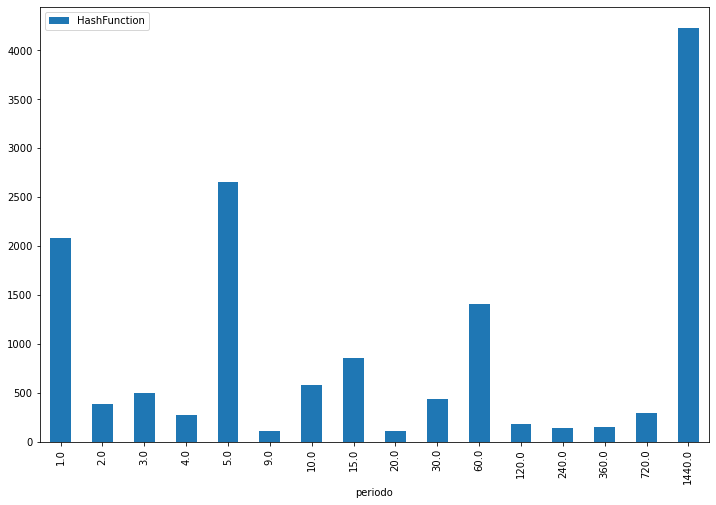

In [18]:
# separar funcones con periodos mas relevantes enlistados ateriormente 
temp = invoc_per_func[['periodo','HashFunction']]
countt= temp.groupby('periodo').count()
countt = countt[countt['HashFunction']>100]
countt.plot(kind='bar', figsize=[12,8])


## primeros minutos de invocacion func, 15 min y 1440 min
graficos de barra

In [4]:
# para encotrar primer minuto de aparicion 
def aparicion(df):
    lista_apariciones = []
    for (index, fila) in df.iterrows():
        cont = 0
        for m in fila.values:
            cont+=1
            if(m == 1):
                lista_apariciones.append(cont)
                break
    df['1era_aparicion'] = lista_apariciones
    del lista_apariciones

In [5]:
def clean_laps_df3(df):
    cond = df.loc[df['Trigger'] != "timer"].index # condicicon para elimitar trigger que no son timer 
    df= df.drop(cond, inplace=False).reset_index(drop = True) # False porque no se puede reset index directo
    df.drop(['HashOwner', 'HashApp', 'Trigger'], axis = 1, inplace = True)
    df.set_index('HashFunction',inplace=True) # para hacer sencillo el reemplazo de # de invocaciones por minuto 
    df=df.where(df <= 1, 1)                 # si se invocó 12veces en un minuto se reeplaza a 1 para analizar periodicidad 
    aparicion(df)
    df = df[['1era_aparicion']] #df con la primera aparicion de todas las funciones
    return df 

In [6]:
# cargamos df con invocaciones
aparicion_func = pd.read_csv("invocations_per_function_md.anon.d01.csv")
with tqdm(total=len(invoc_func), file=sys.stdout) as pbar:
    cont_arch = 0
    for arch in invoc_func:
        if(arch == "invocations_per_function_md.anon.d01.csv"):
            aparicion_func = clean_laps_df3(aparicion_func)                                           
        else:
            aux = pd.read_csv(arch)
            aux = clean_laps_df3(aux)
            aparicion_func = aparicion_func.merge(aux, left_index=True, right_index=True, how='outer',suffixes=("_dia"+str(cont_arch), "_dia"+str(cont_arch+1)))
            del aux
        cont_arch+=1
        pbar.set_description('archivos procesados: %d' %(cont_arch))
        pbar.update(1)
        #time.sleep(1)
aparicion_func


archivos procesados: 14: 100%|█████████████████████████████████████████████████████████| 14/14 [02:51<00:00, 12.25s/it]


,1era_aparicion_dia1,1era_aparicion_dia2,1era_aparicion_dia3,1era_aparicion_dia4,1era_aparicion_dia5,1era_aparicion_dia6,1era_aparicion_dia7,1era_aparicion_dia8,1era_aparicion_dia9,1era_aparicion_dia10,1era_aparicion_dia11,1era_aparicion_dia12,1era_aparicion_dia13,1era_aparicion_dia14
HashFunction,,,,,,,,,,,,,,
000cb18d3a6703acb3d41a0f3e91340660564d1f64fe9df6f231991a17d0a94f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,1.0,1.0,1.0,1.0,1.0,1.0
000f2da683015ed9906123feadcb750a58335a0fb8eaa08eee4146445240dc1a,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0014b6aab764a8fe6d6ca6d09e13ad934c870b109ddb56ceacd87ca5e1a90f6f,NaN,NaN,NaN,1056.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00151cd7f14a561f701eaf0b94cea5bde2f32f90c9d0a1bb9afcce37ef09ce6a,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00174b212af53df7f8b757f224ca03623d7469947141937615e628de3e8a1770,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff53d223baae383544a75e971c297c13d99b24781efd955ccc08fc3b63885f7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0
fff53d9ddaca0baefc44f74794bd32dc029076dc025e296e809ccbe69fc919e6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
fff700ac64335df6ec9b08baa38811ea957d54ae601d5d5af06f3fb98807111b,181.0,181.0,181.0,181.0,181.0,181.0,181.0,181.0,181.0,181.0,181.0,181.0,181.0,181.0


In [7]:
aparicion_func.dropna(inplace = True)
moda =aparicion_func.mode(axis=1).iloc[:, 0] # gaurdamos moda,para asignar a 1era aparicion general
desv = aparicion_func.std(axis=1)
aparicion_func["1ra_aparicion"] = moda.round(0)
aparicion_func["Desv_Est"] = desv.round(0)
aparicion_func= aparicion_func[["1ra_aparicion","Desv_Est"]]
del moda
del desv
aparicion_func

,1ra_aparicion,Desv_Est
HashFunction,,
000f2da683015ed9906123feadcb750a58335a0fb8eaa08eee4146445240dc1a,1.0,0.0
00174b212af53df7f8b757f224ca03623d7469947141937615e628de3e8a1770,1.0,0.0
002d6666d5086611a8ea111dc5bcca2978ee5f2b08da82deef579d5ed8765979,1.0,0.0
002f14a3c86f140f60aacb99dde244ca728a5adef2a1a256d7b273c6adee332f,121.0,0.0
003113d23daef08fb19592d506530f9929614aca4520830fd9b35e77fb8f4f79,1.0,1.0
...,...,...
fff15d76bbbd02d0f6f7994f5b01767453a3f32a9888c29f87874626050f92e0,361.0,0.0
fff53d223baae383544a75e971c297c13d99b24781efd955ccc08fc3b63885f7,1.0,4.0
fff53d9ddaca0baefc44f74794bd32dc029076dc025e296e809ccbe69fc919e6,1.0,0.0


In [8]:
invoc_per_func = pd.read_csv("invocaciones_timer_3.csv")
periodo_funcines= invoc_per_func[['HashFunction','periodo','Desv_Est']]
periodo_funcines.set_index('HashFunction',inplace=True) # para hacer sencillo el reemplazo de # de invocaciones por minuto 
periodo_funcines

,periodo,Desv_Est
HashFunction,,
000f2da683015ed9906123feadcb750a58335a0fb8eaa08eee4146445240dc1a,30.0,0.0
00174b212af53df7f8b757f224ca03623d7469947141937615e628de3e8a1770,4.0,0.0
002d6666d5086611a8ea111dc5bcca2978ee5f2b08da82deef579d5ed8765979,9.0,0.0
002f14a3c86f140f60aacb99dde244ca728a5adef2a1a256d7b273c6adee332f,1440.0,0.0
003113d23daef08fb19592d506530f9929614aca4520830fd9b35e77fb8f4f79,5.0,0.0
...,...,...
fff15d76bbbd02d0f6f7994f5b01767453a3f32a9888c29f87874626050f92e0,1440.0,0.0
fff53d223baae383544a75e971c297c13d99b24781efd955ccc08fc3b63885f7,15.0,0.0
fff53d9ddaca0baefc44f74794bd32dc029076dc025e296e809ccbe69fc919e6,3.0,0.0


In [9]:
aparicion_func = aparicion_func.merge(periodo_funcines, left_index=True, right_index=True, how='inner')
aparicion_func = aparicion_func[["periodo","1ra_aparicion"]]
aparicion_func

,periodo,1ra_aparicion
HashFunction,,
000f2da683015ed9906123feadcb750a58335a0fb8eaa08eee4146445240dc1a,30.0,1.0
00174b212af53df7f8b757f224ca03623d7469947141937615e628de3e8a1770,4.0,1.0
002d6666d5086611a8ea111dc5bcca2978ee5f2b08da82deef579d5ed8765979,9.0,1.0
002f14a3c86f140f60aacb99dde244ca728a5adef2a1a256d7b273c6adee332f,1440.0,121.0
003113d23daef08fb19592d506530f9929614aca4520830fd9b35e77fb8f4f79,5.0,1.0
...,...,...
fff15d76bbbd02d0f6f7994f5b01767453a3f32a9888c29f87874626050f92e0,1440.0,361.0
fff53d223baae383544a75e971c297c13d99b24781efd955ccc08fc3b63885f7,15.0,1.0
fff53d9ddaca0baefc44f74794bd32dc029076dc025e296e809ccbe69fc919e6,3.0,1.0


In [10]:
aparicion_func['HashFunction'] = aparicion_func.index
aparicion_func.reset_index(drop = True, inplace = True)

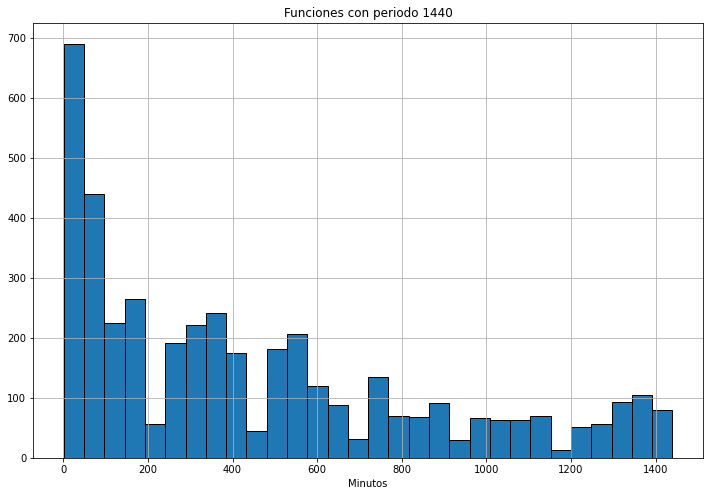

In [153]:
minutos1440 = aparicion_func[aparicion_func['periodo'] == 1440]
plt.figure(figsize=(12,8))
histograma= plt.hist(minutos1440['1ra_aparicion'], 30, ec='black')# guardamos los elementos de BarContainer por que el primer elelemto
#histograma[0] son la cantodad/frecuencia de elemento de cada clase del histograma
plt.xlabel('Minutos')
plt.title('Funciones con periodo 1440')
plt.grid(True)
rang = 0
rangos=[]
for i in range(30):
    if (i == 29):
        rangos.append("["+str(rang)+" - "+str(rang+48)+"]")
    else:
        rangos.append("["+str(rang)+" - "+str(rang+48)+")")
    rang+= 48

dfvalores = pd.DataFrame(list(zip(rangos,histograma[0])), columns = ["clase","frecuencia"])


valores de cada clase del histograma 
rangos o contenedores de valles: 5, 10, 15, 20, 25 

In [154]:
dfvalores.iloc[[4,9,14,19,24]] #

,clase,frecuencia
4,[192 - 240),57.0
9,[432 - 480),44.0
14,[672 - 720),31.0
19,[912 - 960),29.0
24,[1152 - 1200),13.0


Text(0.5, 1.0, 'Funciones con periodo 15')

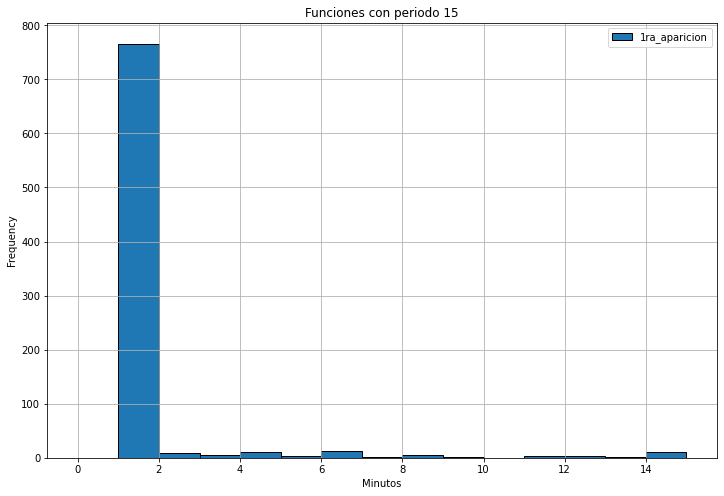

In [156]:
minutos15 = aparicion_func[aparicion_func['periodo'] == 15]
minutos15['1ra_aparicion'].plot.hist(figsize=[12,8], bins=range(16), legend=True, grid=True, ec='black')
plt.xlabel('Minutos')
plt.title('Funciones con periodo 15')

Text(0.5, 1.0, 'Funciones con periodo 5')

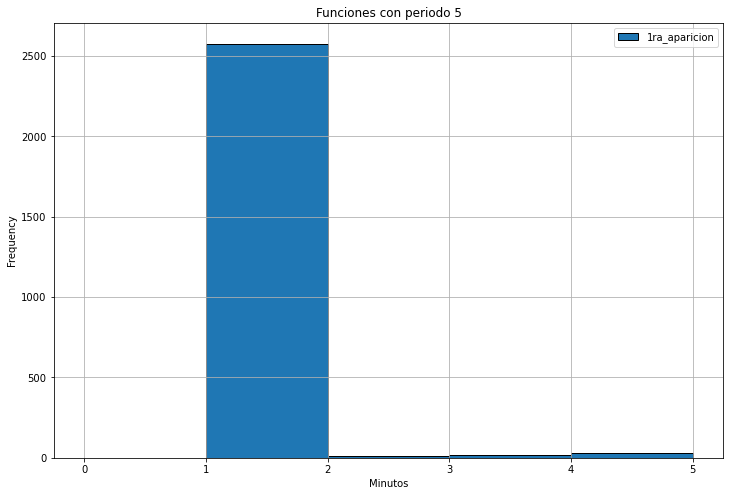

In [19]:
minutos5 = aparicion_func[aparicion_func['periodo'] == 5]
minutos5['1ra_aparicion'].plot.hist(figsize=[12,8],bins=range(6), legend=True, grid=True, ec='black')
plt.xlabel('Minutos')
plt.title('Funciones con periodo 5')

Text(0.5, 1.0, 'Funciones con periodo 30')

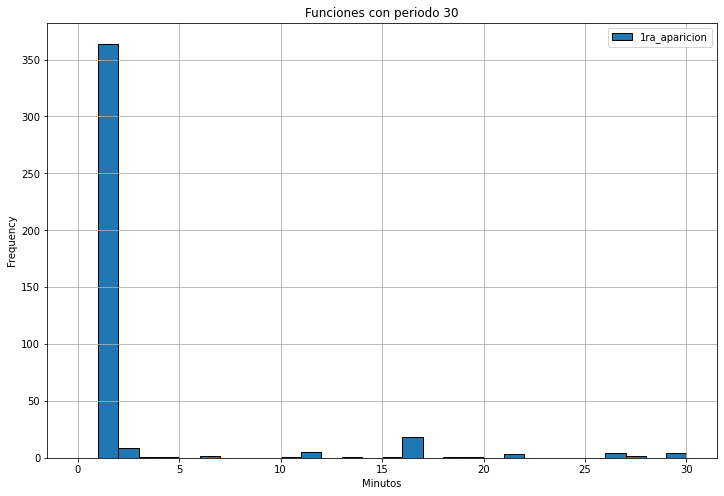

In [20]:
minutos30 = aparicion_func[aparicion_func['periodo'] == 30]
minutos30['1ra_aparicion'].plot.hist(figsize=[12,8],bins=range(31), legend=True, grid=True, ec='black')
plt.xlabel('Minutos')
plt.title('Funciones con periodo 30')

Text(0.5, 1.0, 'Funciones con periodo 20')

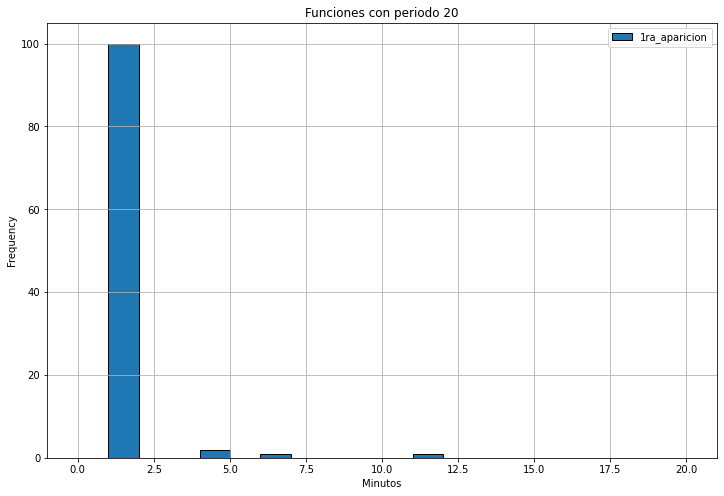

In [26]:
minutos20 = aparicion_func[aparicion_func['periodo'] == 20]
minutos20['1ra_aparicion'].plot.hist(figsize=[12,8],bins=range(21), legend=True, grid=True, ec='black')
plt.xlabel('Minutos')
plt.title('Funciones con periodo 20')

In [17]:
#se guarda para futuros usos, omitir de ser necesario
aparicion_func.to_csv("aparicion.csv", index=False)